# Transfer Learning from the Foundations

#### Last Time
We [just finished](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11_train_imagenette_my_reimplementation.ipynb?flush_cache=true) implementing XResNets. Our code was architected to be quite concise while remaining eminently extensible, allowing us to instantiate any flavor of XResNet that we desire, in just one line of code!

#### Transfer Learning
Here we dive into transfer learning. Our ultimate goal will be to build an image classifier that is able to distinguish between the different pet breeds represented by the images in the [Oxford-IIIT Pet dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/).

To demonstrate how transfer learning works, we'll actually begin by pre-training a model for several epochs on another dataset that's loosely similar to the Pets dataset. We then perform a survey of techniques integral to successful application of transfer learning:
1. Transforming the pretrained network into a bottleneck and adding onto it a custom head.
2. Fine-tuning the bottleneck+custom head network on the Pets imageset by gradually unfreezing its layers.
3. No batchnorm transfer: ensure that pre-trained batchnorm layers are never frozen and are always trained from scratch on new dataset.
4. Appying discriminative learning rate/momentum schedules to the network's different layer groups.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_11 import *

We'll begin by training an XResNet34 bottleneck on the [Imagewoof dataset](https://github.com/fastai/imagenette). Similar in spirit to Imagenette, Imagewoof designed to be a somewhat tougher challenge, in that it contains images belonging 10 classes that represent different dog breeds.

In [18]:
imagewoof_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof'

In [19]:
path = datasets.untar_data(imagewoof_url)
size=128
bs=64
tfms = [MakeRGB(), RandomResizedCrop(size, scale=(0.35, 1)), to_byte_tensor, to_float_tensor, PilRandomFlip()]
val_tfms = [MakeRGB(), CenterCrop(size), to_byte_tensor, to_float_tensor]
data = (ImageList.from_files(path, tfms=tfms)
        .to_split(partial(grandparent_splitter, valid_name='val'))
        .to_label(parent_labeler, y_processor=CategoryProcessor())
        .to_databunch(bs, channels_in=3, channels_out=10, num_workers=4))

In [20]:
data.valid_ds.x.tfms = val_tfms
data.valid_ds.x.tfms

 <function exports.nb_08.to_byte_tensor(item)>,
 <function exports.nb_08.to_float_tensor(item)>]

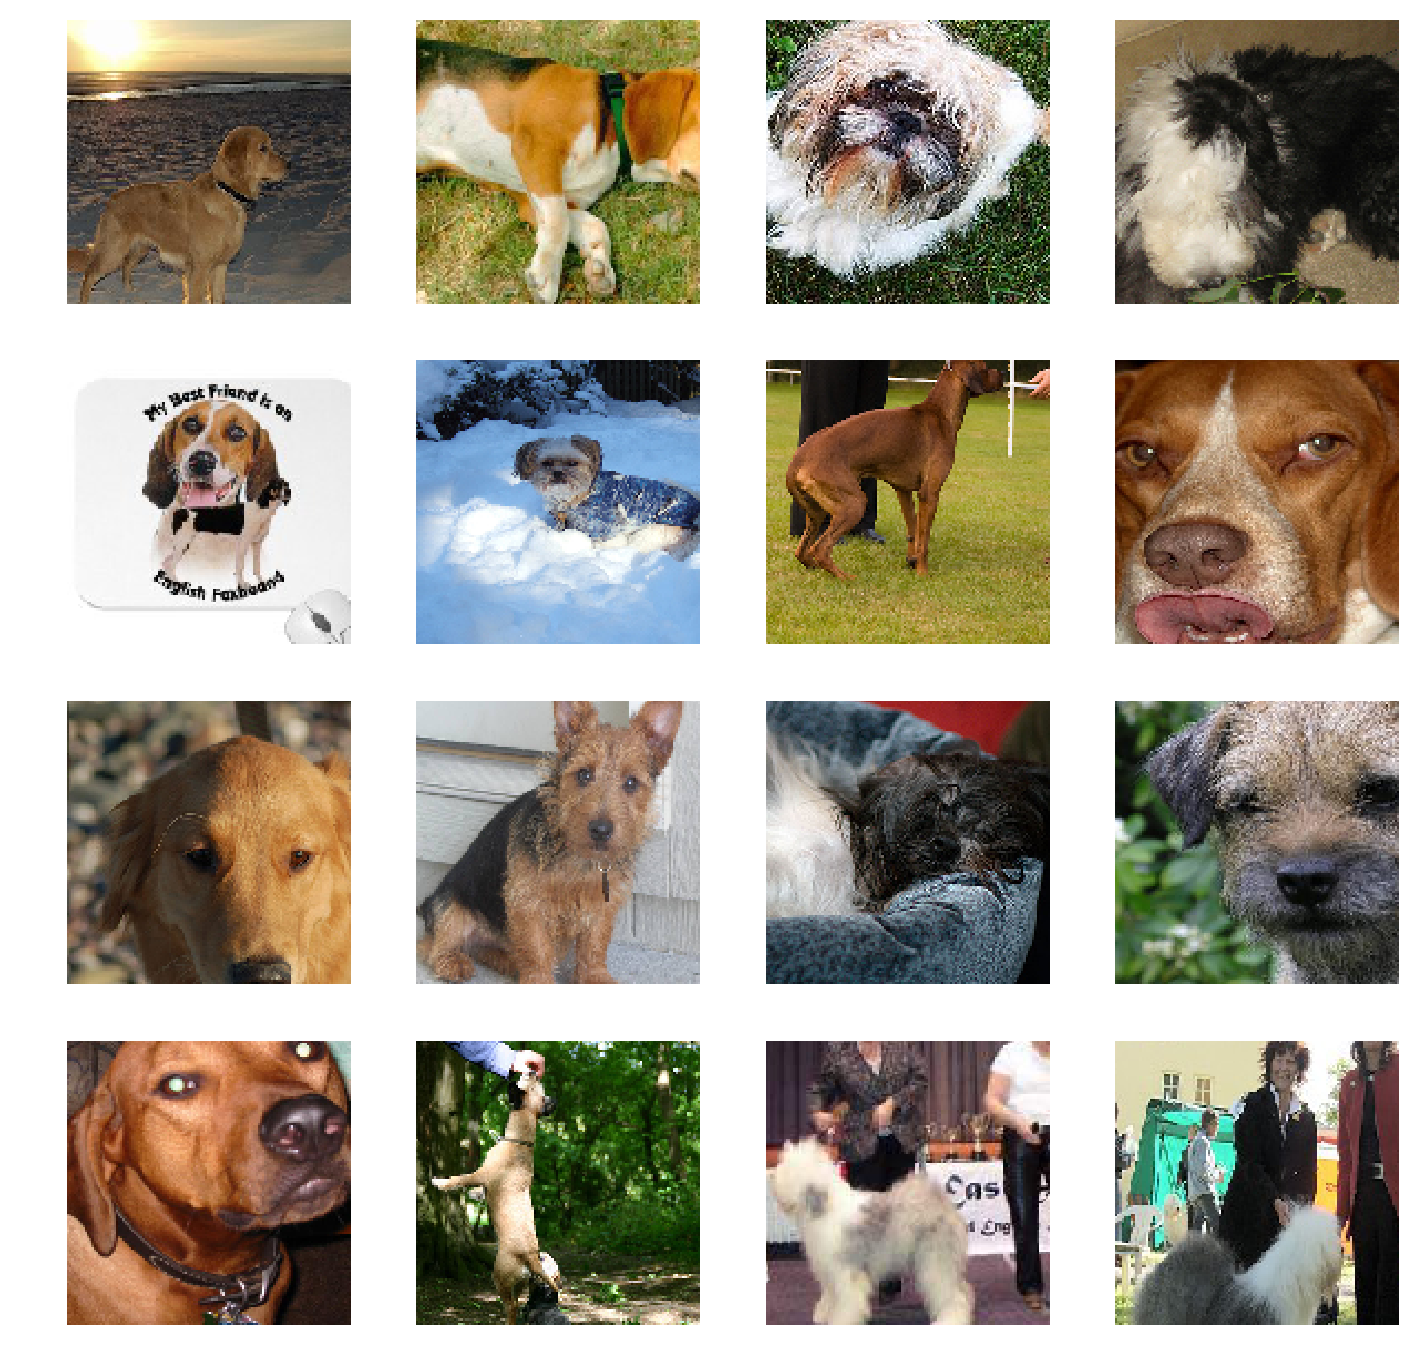

In [23]:
dog_breeds = next(iter(data.train_dl))
x = dog_breeds[0][:16]
show_batch(x)

In [38]:
y = dog_breeds[1][:16]
y

tensor([2, 9, 8, 4, 5, 8, 1, 9, 2, 6, 8, 0, 1, 0, 4, 4])

Here are the ImageNet category codes for each of the dog breeds included in the above sample of 16 images, in order (left->right, top row->bottom row):

In [52]:
data.train_ds.y_processor.deprocess(y)

['n02099601',
 'n02088364',
 'n02086240',
 'n02105641',
 'n02089973',
 'n02086240',
 'n02087394',
 'n02088364',
 'n02099601',
 'n02096294',
 'n02086240',
 'n02093754',
 'n02087394',
 'n02093754',
 'n02105641',
 'n02105641']

The above codes map to these dog breed names: 

* 'n02099601': Golden retriever,
* 'n02088364': Beagle,
* 'n02086240': Shih-Tzu,
* 'n02105641': Old English sheepdog,
* 'n02089973': English foxhound,
* 'n02086240': Shih-Tzu,
* 'n02087394': Rhodesian ridgeback,
* 'n02088364': Beagle,
* 'n02099601': Golden retriever,
* 'n02096294': Australian terrier,
* 'n02086240': Shih-Tzu,
* 'n02093754': Border terrier,
* 'n02087394': Rhodesian ridgeback,
* 'n02093754': Border terrier,
* 'n02105641': Old English sheepdog,
* 'n02105641': Old English sheepdog

The following two of the ten total breeds are not represented in the above sample:
* Samoyed ('n02111889'), 
* Dingo ('n02115641')


## Pretraining a XResNet34 model for 40 epochs on Imagewoof

In [56]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
learn = cnn_learner(XResNet34, data, loss_func, opt_func, batchnorm=norm_imagenette)

Another convenience method to let us quickly set up a 1-cycle learning rate/momentum scheduler:

In [57]:
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

In [58]:
lr = 3e-3
pct_start = 0.5
schedules = sched_1cycle(lr, pct_start)

In [59]:
learn.fit(40, schedules)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.108889,0.259274,2.120999,0.276000,00:38
1,1.972255,0.335715,2.131866,0.308000,00:38
2,1.871050,0.390878,2.034112,0.320000,00:37
3,1.786484,0.431347,2.130924,0.318000,00:38
4,1.726400,0.460254,2.145304,0.326000,00:38
5,1.687627,0.471335,2.056789,0.344000,00:37
6,1.655393,0.496226,1.899663,0.374000,00:38
7,1.610770,0.515979,1.845615,0.408000,00:38
8,1.580015,0.530593,2.090016,0.372000,00:37
9,1.549703,0.549382,2.441221,0.368000,00:38


Now we'll save this model, using its `state_dict`.

In [60]:
state_dict = learn.model.state_dict()
type(state_dict)

collections.OrderedDict

In [61]:
', '.join(state_dict.keys())

'0.0.weight, 0.1.weight, 0.1.bias, 0.1.running_mean, 0.1.running_var, 0.1.num_batches_tracked, 1.0.weight, 1.1.weight, 1.1.bias, 1.1.running_mean, 1.1.running_var, 1.1.num_batches_tracked, 2.0.weight, 2.1.weight, 2.1.bias, 2.1.running_mean, 2.1.running_var, 2.1.num_batches_tracked, 4.0.convs.0.0.weight, 4.0.convs.0.1.weight, 4.0.convs.0.1.bias, 4.0.convs.0.1.running_mean, 4.0.convs.0.1.running_var, 4.0.convs.0.1.num_batches_tracked, 4.0.convs.1.0.weight, 4.0.convs.1.1.weight, 4.0.convs.1.1.bias, 4.0.convs.1.1.running_mean, 4.0.convs.1.1.running_var, 4.0.convs.1.1.num_batches_tracked, 5.0.convs.0.0.weight, 5.0.convs.0.1.weight, 5.0.convs.0.1.bias, 5.0.convs.0.1.running_mean, 5.0.convs.0.1.running_var, 5.0.convs.0.1.num_batches_tracked, 5.0.convs.1.0.weight, 5.0.convs.1.1.weight, 5.0.convs.1.1.bias, 5.0.convs.1.1.running_mean, 5.0.convs.1.1.running_var, 5.0.convs.1.1.num_batches_tracked, 5.0.idconv.0.weight, 5.0.idconv.1.weight, 5.0.idconv.1.bias, 5.0.idconv.1.running_mean, 5.0.idconv.1.

Here's how we would use this state dict to access some saved parameters:

In [62]:
state_dict['10.bias']

tensor([ 0.0245, -0.0152,  0.0179, -0.0178,  0.0031, -0.0574,  0.0014,  0.0018,
        -0.0132,  0.0453], device='cuda:0')

In [63]:
model_path = path/'models'
model_path.mkdir(exist_ok=True)

While it's possible to save the model and its architecture in their entirety, things work better in PyTorch if you just save its parameters via the state dict, and then recreate the model later on:

In [64]:
torch.save(state_dict, model_path/'image_woof5')

## Load the Oxford-IIIT Pets Dataset
Now it's time to load in the dataset that is the goal of our classification task. The Pets dataset contains about 200 images for each of the 37 cat or dog breeds; there are 12 cat breeds and 25 dog breeds. 

In [65]:
pets = datasets.untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet')

In [67]:
pets.ls()

[PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/annotations')]

In [68]:
pets_path = pets/'images'

Here's a helper function to randomly split the pets dataset off into train and validation sets:

In [69]:
random.seed(42)

In [70]:
#export
def random_splitter(fn, p_valid): return random.random() < p_valid

And here's a helper function that we can use to generate the proper labels for each Pets image:

In [77]:
def pet_labeler(fn): return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

In [79]:
num_classes=37
pet_data = (ImageList.from_files(pets_path, tfms=tfms)
            .to_split(partial(random_splitter, p_valid=0.1))
            .to_label(pet_labeler, y_processor=CategoryProcessor())
            .to_databunch(bs, channels_in=3, channels_out=num_classes, num_workers=4))

In [80]:
pet_data.valid_ds.x.tfms = val_tfms

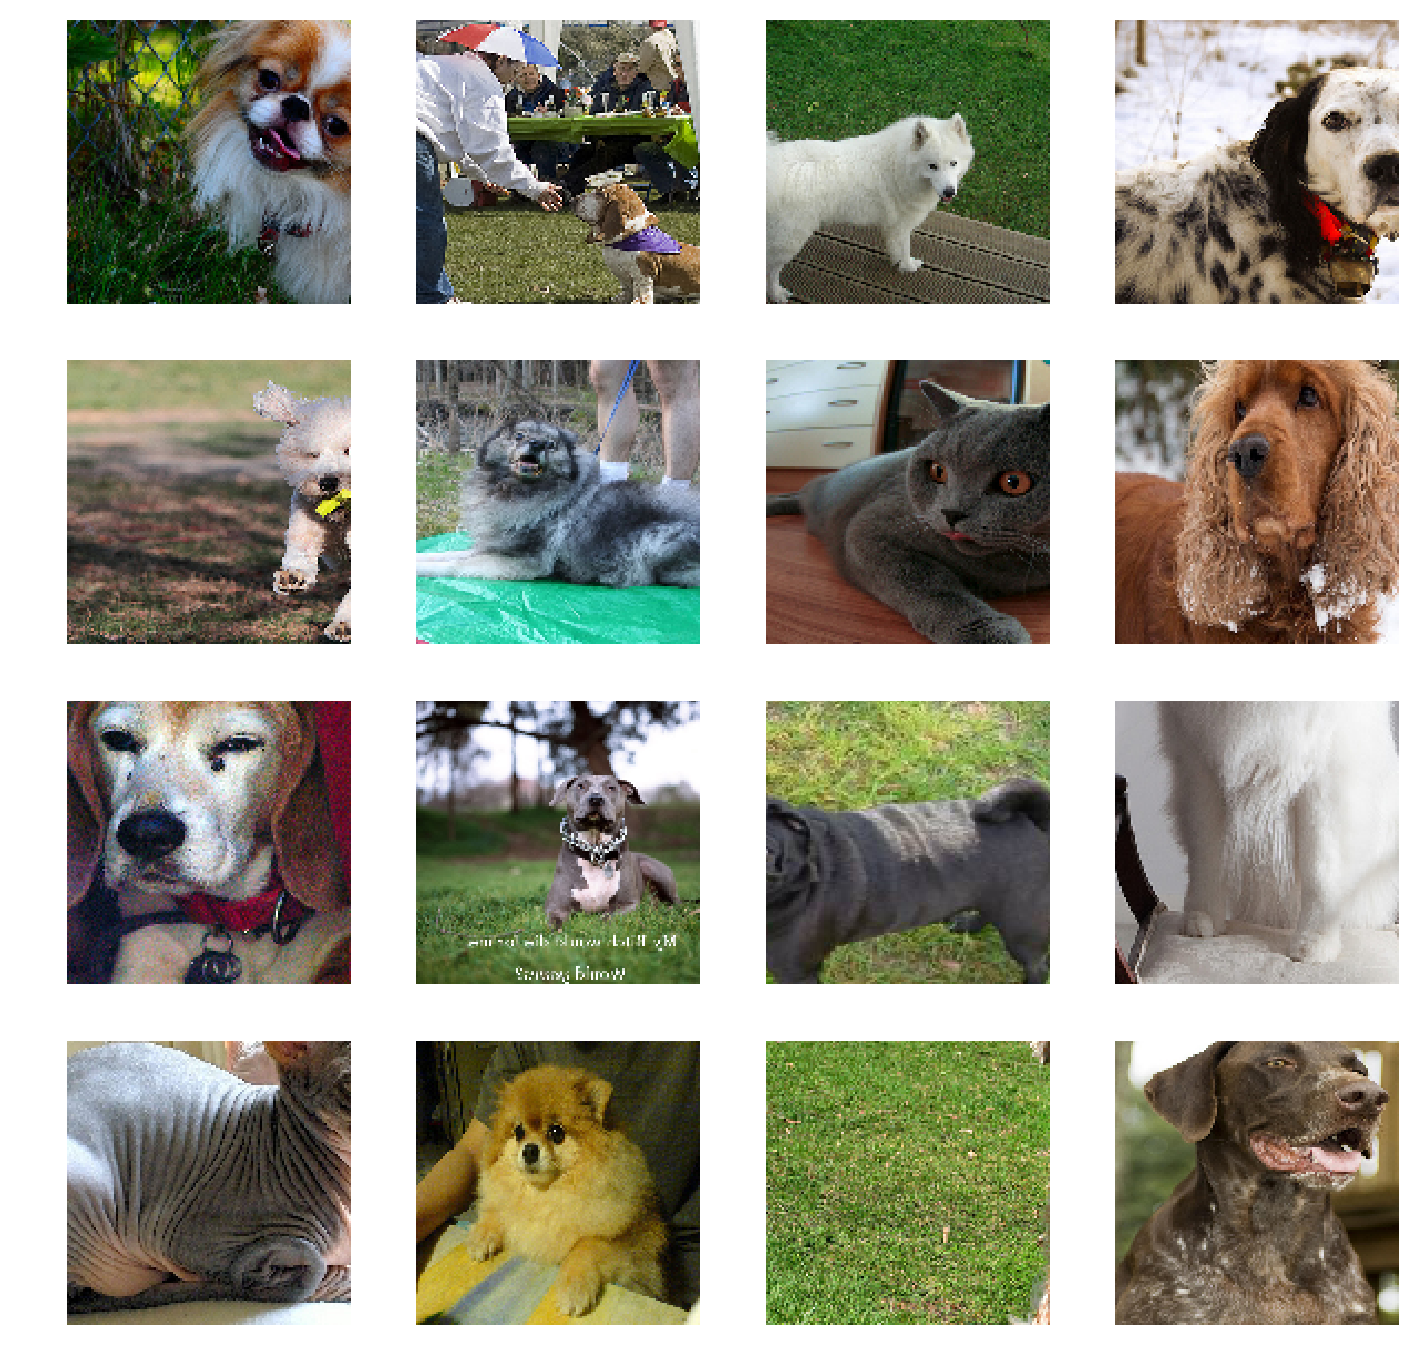

In [81]:
pet_breeds = next(iter(pet_data.train_dl))
x = pet_breeds[0][:16]
show_batch(x)

In [82]:
y = pet_breeds[1][:16]
y

tensor([26,  4, 21, 16, 33,  5, 15, 22, 32, 23,  3, 21, 35, 18, 16,  8])

Below are the pet breeds, in order (left->right, top row->bottom row), for each of the above sample of 16 images from the Pets training set:

In [85]:
pet_data.train_ds.y_processor.deprocess(y)

['japanese_chin',
 'basset_hound',
 'samoyed',
 'english_setter',
 'wheaten_terrier',
 'keeshond',
 'British_Shorthair',
 'english_cocker_spaniel',
 'beagle',
 'american_pit_bull_terrier',
 'pug',
 'samoyed',
 'Sphynx',
 'pomeranian',
 'english_setter',
 'german_shorthaired']

And here are all 37 pet breeds that are found in the Pets dataset:

In [87]:
print(len(pet_data.train_ds.y_processor.vocab))
pet_data.train_ds.y_processor.vocab

37


['saint_bernard',
 'staffordshire_bull_terrier',
 'newfoundland',
 'pug',
 'basset_hound',
 'keeshond',
 'great_pyrenees',
 'chihuahua',
 'german_shorthaired',
 'Abyssinian',
 'scottish_terrier',
 'Siamese',
 'Bengal',
 'Egyptian_Mau',
 'havanese',
 'British_Shorthair',
 'english_setter',
 'Bombay',
 'pomeranian',
 'boxer',
 'Ragdoll',
 'samoyed',
 'english_cocker_spaniel',
 'american_pit_bull_terrier',
 'shiba_inu',
 'Birman',
 'japanese_chin',
 'american_bulldog',
 'Russian_Blue',
 'Persian',
 'yorkshire_terrier',
 'Maine_Coon',
 'beagle',
 'wheaten_terrier',
 'miniature_pinscher',
 'Sphynx',
 'leonberger']

## Setting a Baseline: Train an XResNet34 model on the Pets Dataset without Transfer Learning
To see how much using a pre-trained bottleneck can help us get a decently performing classifier in a minimum of training epochs, let's first attempt to train a non-pre-trained XResNet34 model for 5 epochs on the Pets imageset. We'll find further below that training for 5 epochs using a pre-trained bottleneck (which is what the XResNet34 that we trained on Imagewoof above will serve as) provides superior results!

In [88]:
learn = cnn_learner(XResNet34, pet_data, loss_func, opt_func, batchnorm=norm_imagenette)

In [89]:
learn.fit(5, schedules)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.482780,0.085749,3.543143,0.063969,00:23
1,3.369109,0.115640,3.900551,0.096606,00:21
2,3.181134,0.160024,3.520940,0.125326,00:21
3,2.914172,0.238376,2.973182,0.218016,00:21
4,2.647063,0.328502,2.828418,0.268930,00:21


Uhg. Only just over 25% validation accuracy after 5 epochs. Using a pre-trained bottleneck will surely help us beat this. Let's see how to implement it!

## Transfer Learning Technique 1: Attching a custom head to a pre-trained bottleneck
We first need to load and re-construct the XResNet34 model that we trained for 40 epochs on Imagewoof. Then, we'll remove its final layer and replace with a network head that has the proper number of output channels (37) so as to be compatible with the number of classes in the Pets dataset. Recall that Imagewoof only has 10 classes, so we won't be able to use our pre-trained XResNet34 network's head for the pet breed classification task.

In [92]:
# Create a Learner object to store the weights saved from our pre-trained model:
# Note that the 'data' argument is the imagewoof data.
learn = cnn_learner(XResNet34, data, loss_func, opt_func, channels_out=10, batchnorm=norm_imagenette)

# Load and place saved parameter weights into the model.
state_dict = torch.load(model_path/'image_woof5')
model = learn.model
model.load_state_dict(state_dict);

We want to use the weights store in all our model's ResNet blocks, and so we'll cut the model off right before its `nn.AdaptiveAvgPool2d` layer, which precedes the fully connected layer with the ten output channels for the Imagewoof classes.

Now how do we find and then remove this `nn.AdaptiveAvgPool2d` layer? It's pretty easy:

In [93]:
cut = next(i for i, o in enumerate(model.children()) if isinstance(o, nn.AdaptiveAvgPool2d))
cut

8

In [94]:
bottleneck_model = model[:cut]

That's all there is to getting our bottleneck model. Now we have to attach a custom head to it. There's a few tricks we can utilize to make this pretty painless, as well:

In [95]:
xb, yb = get_batch(pet_data.valid_dl, learn)
pred = bottleneck_model(xb)
pred.shape

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


torch.Size([128, 512, 4, 4])

In PyTorch, dimension 1 contains the number of channels, and so we know that the final layer of our bottleneck model has 512 channels. This means that in order to add a custom network head, we just need to add an average pooling layer that expects 512 input channels, flatten this layer's output, and then connect to a fully-connected linear layer that will have 37 output channels (one for each class in the Pets dataset).

As for how to go about defining this average pooling layer we'll need, we can just use adaptive avg/max pooling. Just below we've implemented a class to accomplish this, with one wrinkle: we define a layer that is a concatenation of one adaptive avg pool layer and one adaptive max pool layer along the channels dimension. 

Why not just use *only* maxpool or *only* avg pool? Well, using [`AdaptiveConcatPool2d`](https://docs.fast.ai/layers.html#AdaptiveConcatPool2d) instead often improves performance because it gives us the both the *max* and *average* information contained in max pooling and average pooling, respectively. We might as well try and get the best of both worlds!

In [96]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=1):
        super().__init__()
        self.output_size = size
        self.avg_pool = nn.AdaptiveAvgPool2d(size)
        self.max_pool = nn.AdaptiveMaxPool2d(size)
        
    def forward(self, x): return torch.cat([self.max_pool(x), self.avg_pool(x)], dim=1)

Now, we're ready to attach the new head to the pre-trained bottleneck. Because our `AdaptiveConcatPool2d` layer is a concatenation of two adaptive layers, note that its output channels will be *twice* the number of output channels at the top of our original model's bottleneck.

In [97]:
n_in = pred.shape[1]
model_new = nn.Sequential(bottleneck_model,
                          AdaptiveConcatPool2d(),
                          Flatten(),
                          nn.Linear(n_in*2, pet_data.channels_out))

The final step is to place our new model (pre-trained bottleneck + a custom head) into our learner object:

In [98]:
learn.model = model_new

#### Refactor bottleneck + custom head creation into `adapt_model` method
We can refactor all the above steps into one convenient method:

In [99]:
#export
def adapt_model(learner, data):
    cut = next(i for i, o in enumerate(learner.model.children()) if isinstance(o, nn.AdaptiveAvgPool2d))
    bottleneck_model = learner.model[:cut]
    xb, yb = get_batch(data.valid_dl, learner)
    pred = bottleneck_model(xb)
    n_in = pred.shape[1]
    model_new = nn.Sequential(bottleneck_model,
                              AdaptiveConcatPool2d(),
                              Flatten(),
                              nn.Linear(n_in*2, data.channels_out))
    learner.model = model_new

With this convenience method, we can load up our pre-trained model, and cut off its final layer and attach a custom head, all within three lines of code!

In [119]:
learn = cnn_learner(XResNet34, data, loss_func, opt_func, channels_out=10, batchnorm=norm_imagenette)
learn.model.load_state_dict(torch.load(model_path/'image_woof5'))
adapt_model(learn, pet_data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


## Transfer Learning Technique 2: Gradual Unfreezing
We're just about read to begin training our bottleneck model + brand new custom head on the Pets images. Rather than train all layers of this model at once, we'll begin by freezing all bottleneck layers and training only the brand new weights inside the custom head. After a few epochs, we'll unfreeze the rest of the lower layers and fine-tune their weights as well. Doing this saves time, as it forces our model's custom head to tailor itself to the unique characteristics of our Pets dataset. The weights at earlier, bottleneck layers most likely will transfer very well to this classification task, and won't need much extra fune-tuning.

However, there is one crucial detail we can't omit when freezing the lower layers, and that brings us to the next transfer learning technique.

## Transfer Learning Technique 3: No Batchnorm Transfer
Even though we freeze the bottleneck layers of our network for the first few epochs of training, we **MUST** leave their batchnorm layers *unfrozen*! 

Why? [Recall from notebook 07](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/07_batchnorm_my_reimplementation.ipynb?flush_cache=true) that the outputs of batchnorm layers are the result of: subtracting from the batchnorm layer inputs their mean, and dividing this by the batchnorm layer inputs' standard deviation. The means and standard deviations used by each batchnorm layer are *very* specific to the dataset on which that layer was originally trained. In other words, while it is beneficial to use the convolutional layer weights derived from training on another dataset for transfer learning, the batchnorm layer means and standard deviations absolutely do not transfer.

Therefore, though we freeze all a network's bottleneck layers for our first few epochs of training, we must leave all batchnorm layers unfrozen and trainable.

Here's how we can do this. We start by creating a convenience function to freeze/unfreeze any network layers that aren't batchnorm *and* aren't in the custom head:

In [120]:
def set_grad(module, state):
    if isinstance(module, (nn.Linear, nn.BatchNorm2d)): return
    if hasattr(module, 'weight'):
        for param in module.parameters(): param.requires_grad_(state)

First we can use PyTorch's `apply` method to freeze all the appropriate layers in our model:

In [121]:
learn.model.apply(partial(set_grad, state=False));

Now we train the fully-connected final layer and all batchnorm layers using the Pets dataset. Note that we use a somewhat higher learning rate here, because, frankly there is a lot to learn as these layers are necessarily being trained from scratch on brand-new data.

In [122]:
learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.317722,0.794524,1.341771,0.756000,00:36
1,1.168832,0.834591,1.323781,0.770000,00:36
2,1.069490,0.875301,1.300838,0.774000,00:36


Compared to our baseline, this is really impressive: already a near 300% improvement in validation accuracy score! And we haven't even unfrozen the lower layers for fine-tuning. Let's do that right now and also train at a slightly lower learning rate.

In [123]:
learn.model.apply(partial(set_grad, state=True));

In [124]:
learn.fit(5, sched_1cycle(1e-5, 0.3), reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.037474,0.884856,1.288687,0.776000,00:41
1,1.034116,0.888068,1.279081,0.778000,00:41
2,1.030346,0.888148,1.266459,0.782000,00:40
3,1.035705,0.884214,1.266570,0.780000,00:41
4,1.030149,0.887988,1.272731,0.786000,00:40


And with a little extra fine-tuning of lower layers, we're already well over three times better than our baseline.

## Transfer Learning Technique 4: Discriminative learning rates for different parameter groups
But we're not quite finished. There's still one more useful tool we can employ to inch our validation accuracy score even higher. Notice how as we unfroze layers, we also lowered our learning rate. The reason for this is intuitive: the weights of lower layers capture knowledge about features that generalizes to a broader swath of classification tasks. Therefore when performing transfer learning, these layers won't have much more to learn from our dataset's images. The top-most layers, on the other hand, will have much more they need to learn about the quirks of the dataset of the classification task at hand.

This should lead us to wonder if it might make sense to build some sort of learning rate training regime where the different layer groups in a network simultaneously get trained at different learning rates, that are ideally tailored to "how much" a given layer group needs to learn about the new dataset.

The first question might be: how do we know where to draw the line? What heuristic can we use for splitting our XResNet34 model's layers into different parameter groups? Well, we already know that the final fully connected layer and the batchnorm layers need to be trained from scratch and at a relatively higher learning rate. So that's one group right there.

Other than that, I like to split the bottleneck model in half, into two separate parameter groups. Here's a function that will split my model into these three groups:

In [160]:
def param_group_splitter(model):
    low_lr_group, mid_lr_group, high_lr_group = [], [], []
    bottleneck = model[0]
    half_bottleneck_size = len(bottleneck)//2
    
    # The model's three param groups:
    lower_bottleneck = bottleneck[:half_bottleneck_size] # put in low_lr_group
    upper_bottleneck = bottleneck[half_bottleneck_size:] # put in mid_lr_group
    custom_head = model[1:] # put in high_lr_group
    
    # Put any batchnorm layer params into high_lr_group. 
    # Otherwise place in desired lr_group.
    def _batchnorm_splitter(layer, target_group, high_lr_group):
        if isinstance(layer, nn.BatchNorm2d): high_lr_group += layer.parameters()
        elif hasattr(layer, 'weight'): target_group += layer.parameters()
        for child in layer.children(): _batchnorm_splitter(child, target_group, high_lr_group)
    
    for layer in lower_bottleneck:
        _batchnorm_splitter(layer, low_lr_group, high_lr_group)
            
    for layer in upper_bottleneck:
        _batchnorm_splitter(layer, mid_lr_group, high_lr_group)
            
    high_lr_group += custom_head.parameters()
    
    return low_lr_group, mid_lr_group, high_lr_group

Conveniently, we can use discriminative learning rate groups to accomplish the same thing as gradual unfreezing: for groups we do not yet wish to train, we just set their learning rates to 0. To demonstrate this, I'll eventually reload the saved model, attach the custom head to the bottleneck, and train using discriminative learning rates. We'll observe how this approach compares to the more simple gradual unfreezing strategy that almost reached a 79% validation accuracy.

First off, however, let's test out the param group splitter function:

In [146]:
learn = cnn_learner(XResNet34, data, loss_func, opt_func, channels_out=10, batchnorm=norm_imagenette)
learn.model.load_state_dict(torch.load(model_path/'image_woof5'))
adapt_model(learn, pet_data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [161]:
low, mid, high = param_group_splitter(learn.model)

We should make sure that all model parameters ended up in a param group:

In [162]:
test_eq(len(low)+len(mid)+len(high), len(list(learn.model.parameters())))

We'll also need to reimplement our `sched_1cycle` convenience method that sets up a 1-cycle learning rate/momentum scheduler -- we need it to be able to create separate lr schedules for each of our model's param groups:

In [167]:
#export
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

We'll begin by setting learning rates to 0 for all parameter groups outside of the custom head and batchnorm layers. This will make for a set of training conditions that is identical to our previous approach of freezing (setting `param.requires_grad_` to False) for these layers.

In [168]:
discriminative_lr_schedule = sched_1cycle([0, 0, 3e-2], 0.5)

Now, you may think that we're ready to jump ahead and begin training. Not so fast! Notice that we've got a lot going on in the training regime that we've designed. Some layers will be training, others won't, and all the while, our learning rate/momentum for the layers that *are* training will be following a 1-cycle policy. How can we ensure that everything will work as expected? For example, it's not like Python would throw an error if my learning rate were lower or higher than I'd expected, or if some layers that shouldn't be getting trained at a particular point were, in fact, getting trained. 

The bottom line is: need a way to verify that param groups and their hyperparameter values are set as we intend for them to be. One really good way to do this is to, unsurprisingly, create a callback that we will use to hook into our model and return this information to us.

In [169]:
#export
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name, self.f = cb_name, f
    def __call__(self, cb_name):
        if cb_name == self.cb_name:
            # If a function, f, is passed, then execute it.
            if self.f: self.f(self.run)
            # Otherwise set a normal debug trace.
            else: set_trace()

Here's a function that prints out the number of param groups, as well as hyperparameter values for each of those param groups, as used by the optimizer during training. We can pass it to our learner object via a `DebugCallback()` object:

In [192]:
def _print_det(o):
    print(f'Number of param groups: {len(o.opt.param_groups)}')
    print(f'Hyperparameters for each param group:\n{o.opt.hyperparam_dicts}')
    raise CancelTrainException

Specifically, I'll want to see what the param groups' hyperparameter values are after a backward pass. To assist in this, here's a convenient way to create a variable that stores the name of each of the callbacks in our training loop. I can pick whichever callback I want to investigate by typing `cb_types.` and then hitting <kbd>tab</kbd> complete.

In [193]:
Learner.ALL_CALLBACKS

{'after_backward',
 'after_batch',
 'after_cancel_batch',
 'after_cancel_epoch',
 'after_cancel_train',
 'after_epoch',
 'after_fit',
 'after_loss',
 'after_pred',
 'after_step',
 'begin_batch',
 'begin_epoch',
 'begin_fit',
 'begin_validate'}

In [194]:
#export
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CALLBACKS})

In [195]:
cb_types.after_backward

'after_backward'

Now we're finally ready to perform transfer learning, using the XResNet34 model that's pretrained on Imagewoof along with discriminative learning rates. Notice that I can conveniently pass my `param_group_splitter` function to the `splitter` argument in `cnn_learner`. This will split my bottleneck+custom head XResNet34 model's parameters according to the logic specified in `param_group_splitter`:

In [196]:
learn = cnn_learner(XResNet34, data, loss_func, opt_func, channels_out=10, batchnorm=norm_imagenette, 
                    splitter = param_group_splitter)
learn.model.load_state_dict(torch.load(model_path/'image_woof5'))
adapt_model(learn, pet_data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


Let's use `DebugCallback` to verify that our optimizer will be working with the expected number of hyperparameter groups (3), and that the values for each of these group's hyperparameters (esp. learning rate) are what we'd expect (lr should be 0 for all but the top-most layers' param-group):

In [197]:
learn.fit(1, discriminative_lr_schedule + [DebugCallback(cb_types.after_batch, _print_det)])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


Number of param groups: 3
Hyperparameters for each param group:
[{'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0, 'sqr_mom': 0.99}, {'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0, 'sqr_mom': 0.99}, {'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0030000000000000512, 'sqr_mom': 0.99}]


Everything looks good. Let's train the custom head:

In [198]:
learn.fit(3, discriminative_lr_schedule)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.293311,0.796933,1.608037,0.672000,00:38
1,1.298918,0.781436,1.413061,0.720000,00:38
2,1.158362,0.834912,1.294865,0.772000,00:38


So far so good! Let's see if we can beat the `78.6%` validation accuracy we got with gradual unfreezing, by now fine-tuning all the model's layers, at *different* learning rates:

In [199]:
discriminative_lr_schedule = sched_1cycle([1e-5, 1e-3, 1e-2], 0.3)

In [200]:
learn.fit(5, discriminative_lr_schedule)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.099553,0.857395,1.392132,0.744000,00:40
1,1.135798,0.841176,1.345476,0.752000,00:41
2,1.123231,0.844548,1.277803,0.784000,00:41
3,1.056032,0.870805,1.224200,0.810000,00:41
4,1.021568,0.883491,1.209000,0.808000,00:40


Outstanding! Just like that we got to a validation accuracy score of `81%` after only 5 epochs of fine-tuning. Discriminative learning rates for three param groups for the win!

If this doesn't exemplify the power, and time-saving, of transfer learning, I quite frankly don't know what else could. Needless to say, training an XResNet34 model from scratch on the Pets dataset would have taken much longer than 8 epochs.

Now you might be conceptually curious: Imagewoof is just images of ten dog breeds, while the Oxford-IIIT Pets imageset has both dog and *cat* breeds. Given this, how is it that we can train a model on only dog breeds and have its weights transfer so nicely to differentiating between not only dogs, but cats as well?
* One possibility is that dogs and cats are not as different as they might seem to the human eye.
* Alternatively, Imagewoof has well over 10,000 training pictures, while the Pets dataset has only 7,000+ images. As different as dogs and cats may indeed be, the surplus of images in Imagewoof could have been sufficient to provide our model with enough knowledge about animals that would generalize to the task of differentiating dogs not just from dogs, but from cats as well.

## Export

In [201]:
nb_auto_export()

<IPython.core.display.Javascript object>